# Inspección de los datos y tratamiento de los valores faltantes.

El conjunto de datos Ripe y Rotten contiene datos sobre dos estados del mango. Este es un conjunto de datos multi-variables para determinar el estado de un mango a traves de una imagen.

El conjunto de datos contiene dos estados en los que se puede encontrar un mango que son: Ripe (Maduro) y Rotten (Podrido). Cada estado cuenta con una cantidad de ejemplos registrados. Rotten: 1492 imágenes y Ripe: 497 imágenes para un total de 1.989 ejemplos en el conjunto de datos. 


In [173]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import warnings
import os
import skimage as ski
import statistics
from skimage.data import page
from skimage.measure import regionprops
from scipy.stats import skew, kurtosis

# Inspección de los datos

In [176]:
path_ripe = "ripe_masks"
path_rotten = "rotten_masks"

data_mask = []

def load_images_from_folder(folder_path, label):
    for filename in os.listdir(folder_path):
        if filename.endswith(".npy"):
            mask_path = os.path.join(folder_path, filename)
            mask = np.load(mask_path)
            data_mask.append({'mask': mask, 'label': label, 'mask_path':mask_path})


In [178]:
def extract_mask_properties(mask):
    if mask.ndim > 2:
        mask = np.max(mask, axis=0)
    props = regionprops(mask.astype(int))[0]
    
    # Cálculos derivados
    form_factor = 4 * np.pi * props.area / (props.perimeter ** 2) if props.perimeter > 0 else 0
    aspect_ratio = props.major_axis_length / props.minor_axis_length if props.minor_axis_length > 0 else 0
    
    # Coordenadas para cálculos estadísticos
    coords = np.column_stack(np.where(mask))
    
    properties = {
        # Propiedades básicas
        'area': props.area,
        'perimeter': props.perimeter,
        'eccentricity': props.eccentricity,
        'solidity': props.solidity,
        'major_axis_length': props.major_axis_length,
        'minor_axis_length': props.minor_axis_length,
        'orientation': props.orientation,
        'extent': props.extent,
        
        # Propiedades derivadas
        'form_factor': form_factor,
        'aspect_ratio': aspect_ratio,
        'convex_area': props.convex_area,
        'filled_area': props.filled_area,
        'euler_number': props.euler_number,
        
        # Estadísticas de forma
        'equivalent_diameter': props.equivalent_diameter,
        'bbox_area': props.bbox_area,
        
        # Momentos de Hu (invariantes a rotación, escala y traslación)
        'hu_moment_1': props.moments_hu[0],
        'hu_moment_2': props.moments_hu[1],
        'hu_moment_3': props.moments_hu[2],
        'hu_moment_4': props.moments_hu[3],
        
        # Estadísticas de distribución espacial
        'skewness_x': skew(coords[:, 0]) if len(coords) > 0 else 0,
        'skewness_y': skew(coords[:, 1]) if len(coords) > 0 else 0,
        'kurtosis_x': kurtosis(coords[:, 0]) if len(coords) > 0 else 0,
        'kurtosis_y': kurtosis(coords[:, 1]) if len(coords) > 0 else 0
    }
    
    return properties

In [180]:
def analyze_masks_dataset():
    
    load_images_from_folder(path_ripe, 'Ripe')
    load_images_from_folder(path_rotten, 'Rotten')
    
    print(f"{len(data_mask)} Máscaras cargadas.")
    
    # Crear DataFrame base
    df_mask = pd.DataFrame(data_mask)
    
    # Extraer propiedades de cada máscara
    properties_list = []
    for mask in df_mask['mask']:
        properties = extract_mask_properties(mask)
        properties_list.append(properties)
    
    # Crear DataFrame de propiedades
    df_properties = pd.DataFrame(properties_list)
    
    # Combinar con las etiquetas
    df_properties['label'] = df_mask['label']
    
    return df_properties

In [182]:
def plot_class_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='label', data=df)
    plt.title("Distribución de Clases: Ripe vs Rotten")
    plt.xlabel("Estado del Mango")
    plt.ylabel("Cantidad")
    plt.show()

# Distribución de las clases

In [185]:
def visualize_properties(df):
    print("1. Distribución de clases")
    plot_class_distribution(df)

In [187]:
def plot_boxplots(df):
    # Obtener columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Configurar grid
    n_properties = len(numeric_cols)
    n_cols = 3
    n_rows = (n_properties + n_cols - 1) // n_cols
    
    # Crear figura
    plt.figure(figsize=(20, 5 * n_rows))
    
    for i, prop in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x='label', y=prop, data=df)
        plt.xticks(rotation=45)
        plt.title(prop)
        
        # Formato para números grandes
        if df[prop].max() > 1000:
            plt.gca().yaxis.set_major_formatter(
                plt.FuncFormatter(lambda x, p: format(int(x), ','))
            )
        
        # Rotar etiquetas largas
        if len(prop) > 15:
            plt.xticks(rotation=45)
            
    plt.tight_layout()

In [189]:
def plot_correlation_matrix(df):
    # Obtener columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation = df[numeric_cols].corr()
    
    # Crear máscara para el triángulo superior
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    
    # Crear figura
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5})
    
    plt.title("Matriz de Correlación de Propiedades")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

835 Máscaras cargadas.
1. Distribución de clases


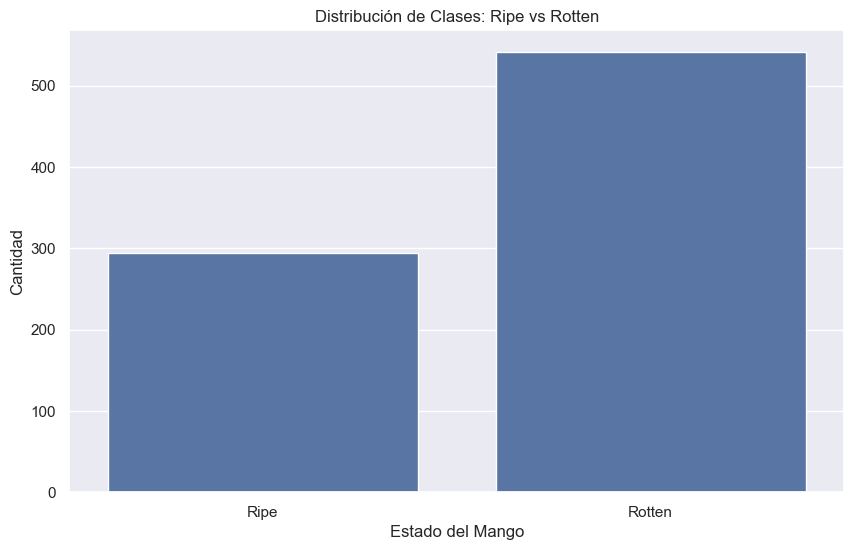

In [191]:
df_properties = analyze_masks_dataset()
visualize_properties(df_properties)

# Distribución de las variables predictoras

Se realiza el análisis de las variables que se encuentran correlacionadas y se elimina aquella que está sobrando.

In [193]:
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   area                 835 non-null    float64
 1   perimeter            835 non-null    float64
 2   eccentricity         835 non-null    float64
 3   solidity             835 non-null    float64
 4   major_axis_length    835 non-null    float64
 5   minor_axis_length    835 non-null    float64
 6   orientation          835 non-null    float64
 7   extent               835 non-null    float64
 8   form_factor          835 non-null    float64
 9   aspect_ratio         835 non-null    float64
 10  convex_area          835 non-null    float64
 11  filled_area          835 non-null    float64
 12  euler_number         835 non-null    int64  
 13  equivalent_diameter  835 non-null    float64
 14  bbox_area            835 non-null    float64
 15  hu_moment_1          835 non-null    flo

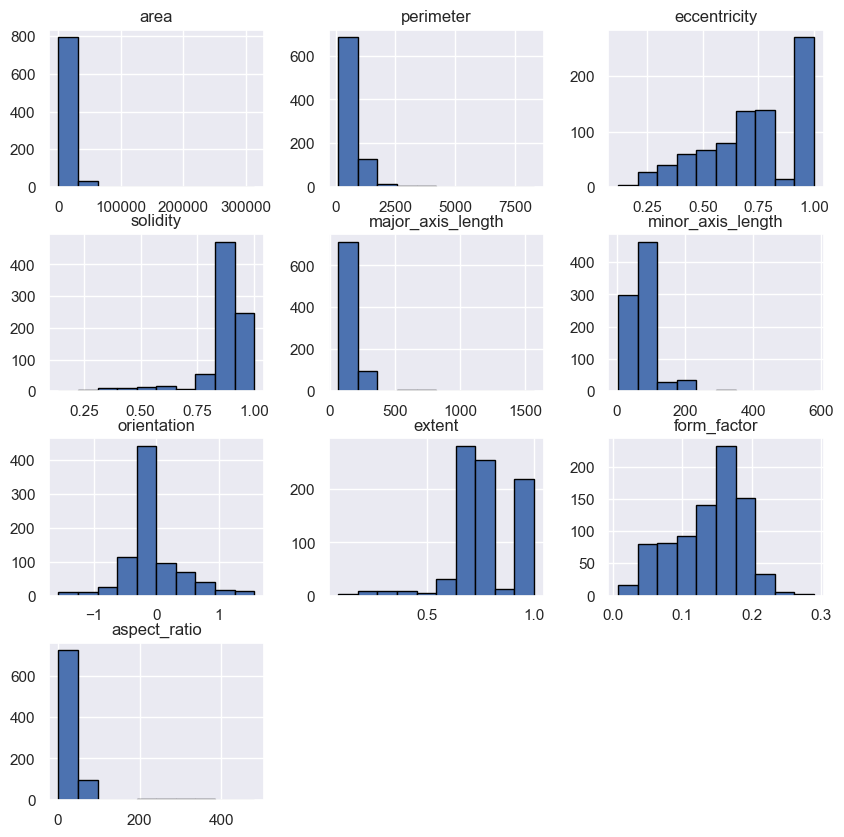

In [195]:
df_properties.hist(['area', 'perimeter', 'eccentricity', 'solidity', 'major_axis_length', 
           'minor_axis_length', 'orientation','extent', 'form_factor', 
           'aspect_ratio'],edgecolor='black', linewidth=1.0)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

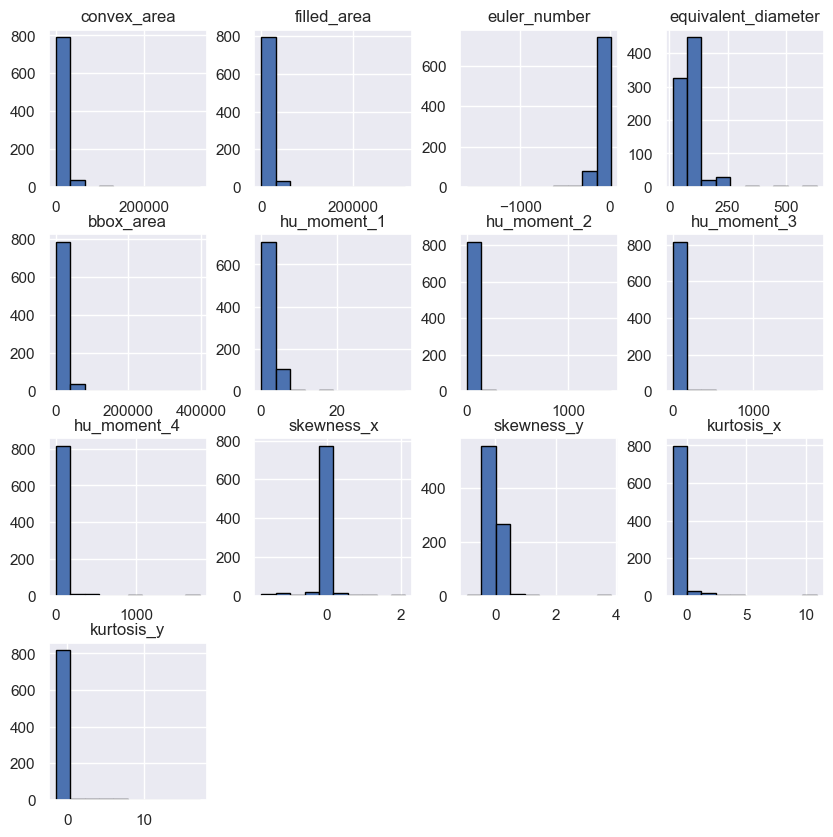

In [198]:
df_properties.hist(['convex_area', 'filled_area', 'euler_number', 'equivalent_diameter', 'bbox_area', 
           'hu_moment_1', 'hu_moment_2','hu_moment_3', 'hu_moment_4', 
           'skewness_x','skewness_y', 'kurtosis_x', 'kurtosis_y'],edgecolor='black', linewidth=1.0)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

# Inspección de las variables predictoras correlacionadas

In [201]:
X_train = df_properties.drop(['label'], axis=1) # Separa las variables predictoras de las variable a predecir
y_train = df_properties['label']

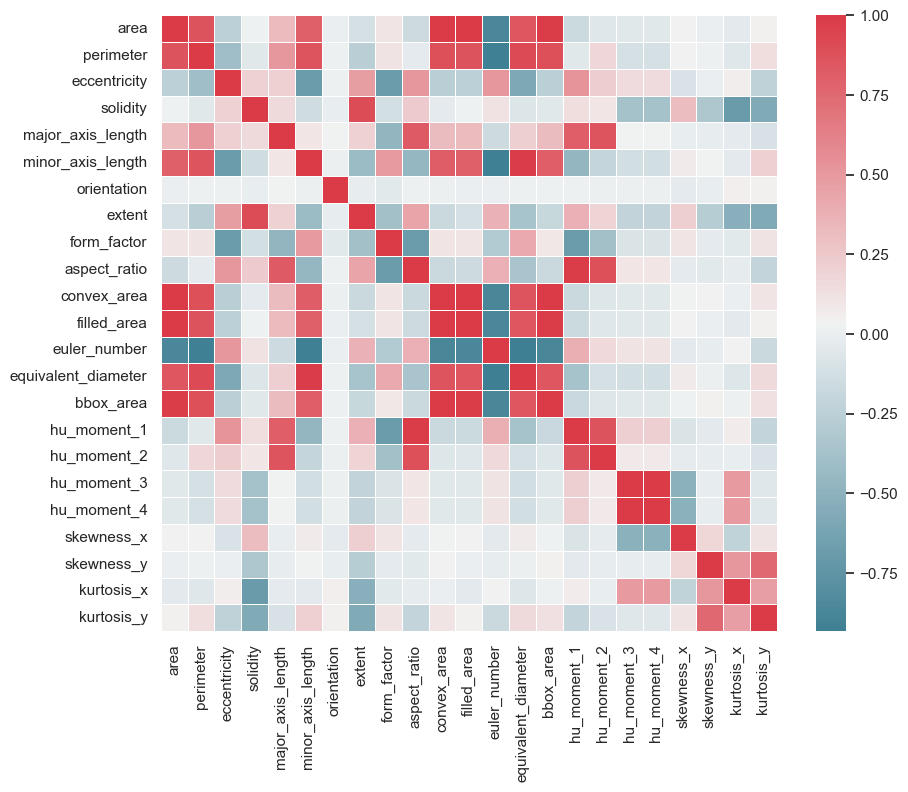

In [203]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), 
          cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax, linewidths=.5)
plt.show() 

In [205]:
def corr_feature_detect(data, threshold):
     
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] # remove the digonal
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            # find all features correlated to a single feature
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            # append the block of features to the list
            correlated_groups.append(correlated_block)
    return correlated_groups

In [207]:
corr = corr_feature_detect(data=X_train,threshold=0.95)
for i in corr:
    print(i,'\n')

      feature1     feature2  corr
0  hu_moment_4  hu_moment_3   1.0 

   feature1     feature2      corr
2      area  filled_area  1.000000
8      area  convex_area  0.996246
13     area    bbox_area  0.990884 

       feature1      feature2      corr
14  hu_moment_1  aspect_ratio  0.987643 

               feature1           feature2      corr
16  equivalent_diameter  minor_axis_length  0.984795 



ValueError: cannot reindex on an axis with duplicate labels

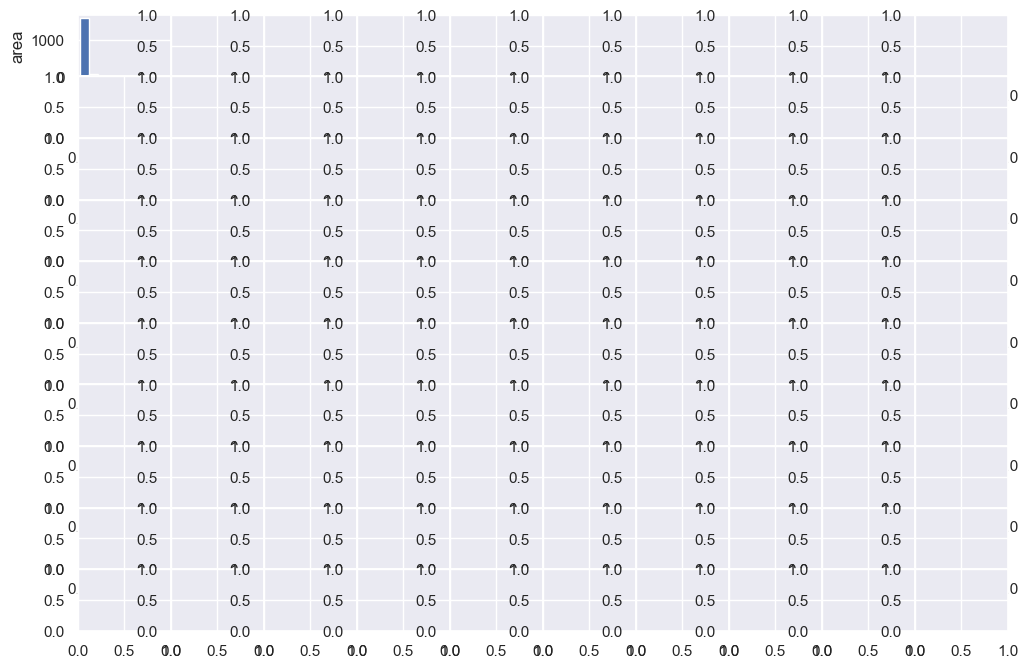

In [209]:
from pandas.plotting import scatter_matrix

cols = ['area','hu_moment_4', 'hu_moment_3', "area", 'filled_area', 'convex_area','hu_moment_1', 'aspect_ratio', 'equivalent_diameter', 'minor_axis_length']
scatter_matrix(X_train[cols], figsize=(12, 8))

In [ ]:
sns.regplot(x='area', y='filled_area', data=X_train);
sns.set(rc={'figure.figsize':(2,5)})
plt.show()

In [ ]:
sns.regplot(x='area', y='convex_area', data=X_train);
sns.set(rc={'figure.figsize':(2,5)})
plt.show()

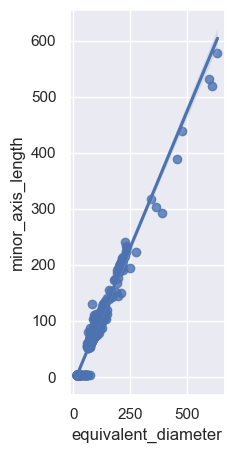

In [213]:
sns.regplot(x='equivalent_diameter', y='minor_axis_length', data=X_train);
sns.set(rc={'figure.figsize':(2,5)})
plt.show()

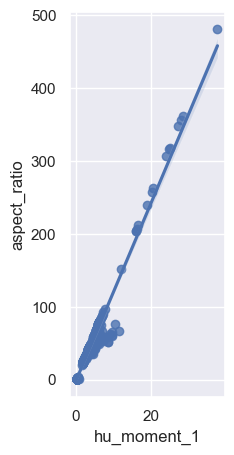

In [215]:
sns.regplot(x='hu_moment_1', y='aspect_ratio', data=X_train);
sns.set(rc={'figure.figsize':(2,5)})
plt.show()

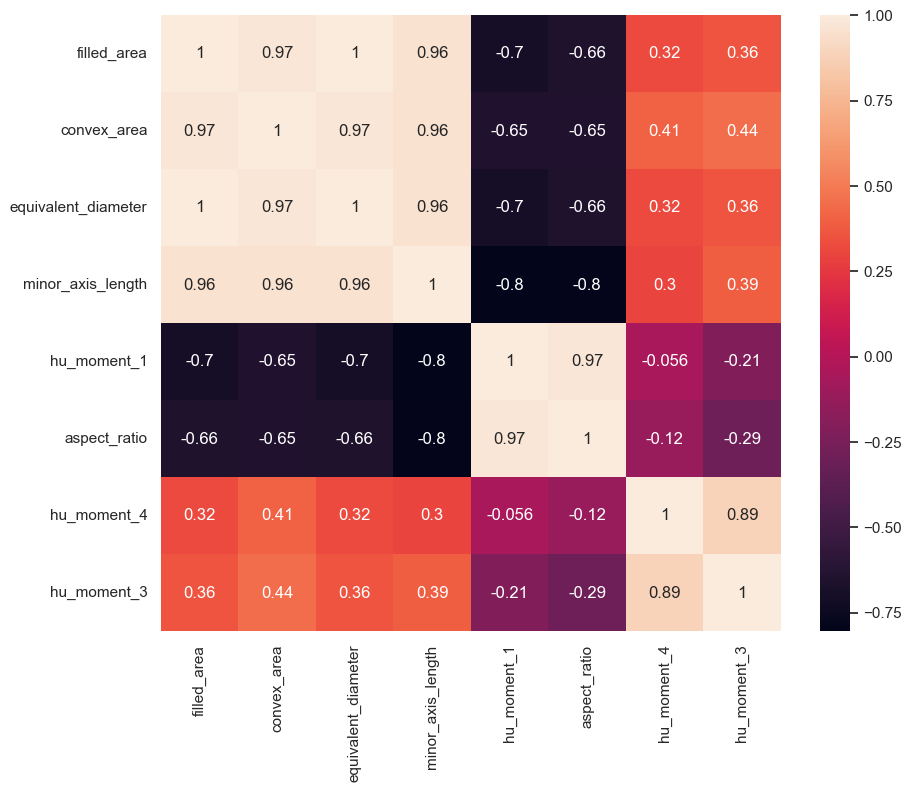

In [217]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X_train[['filled_area', "convex_area", 'equivalent_diameter', 'minor_axis_length', 'hu_moment_1', 'aspect_ratio', 'hu_moment_4', 'hu_moment_3']].corr(method='spearman')
sns.heatmap(corr, annot=True)
plt.show() 

array([[<Axes: xlabel='filled_area', ylabel='filled_area'>,
        <Axes: xlabel='convex_area', ylabel='filled_area'>,
        <Axes: xlabel='equivalent_diameter', ylabel='filled_area'>,
        <Axes: xlabel='minor_axis_length', ylabel='filled_area'>,
        <Axes: xlabel='hu_moment_1', ylabel='filled_area'>,
        <Axes: xlabel='aspect_ratio', ylabel='filled_area'>,
        <Axes: xlabel='hu_moment_3', ylabel='filled_area'>],
       [<Axes: xlabel='filled_area', ylabel='convex_area'>,
        <Axes: xlabel='convex_area', ylabel='convex_area'>,
        <Axes: xlabel='equivalent_diameter', ylabel='convex_area'>,
        <Axes: xlabel='minor_axis_length', ylabel='convex_area'>,
        <Axes: xlabel='hu_moment_1', ylabel='convex_area'>,
        <Axes: xlabel='aspect_ratio', ylabel='convex_area'>,
        <Axes: xlabel='hu_moment_3', ylabel='convex_area'>],
       [<Axes: xlabel='filled_area', ylabel='equivalent_diameter'>,
        <Axes: xlabel='convex_area', ylabel='equivalent_diam

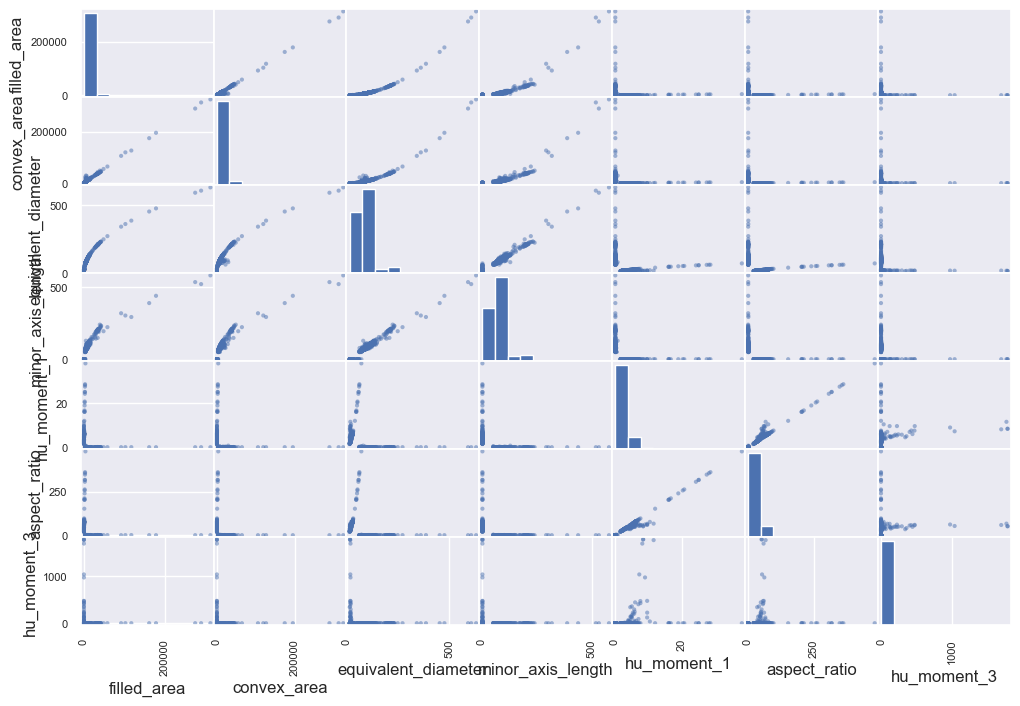

In [219]:
cols = ['filled_area', "convex_area", 'equivalent_diameter', 'minor_axis_length', 'hu_moment_1', 'aspect_ratio', 'hu_moment_3' ]
scatter_matrix(X_train[cols], figsize=(12, 8))

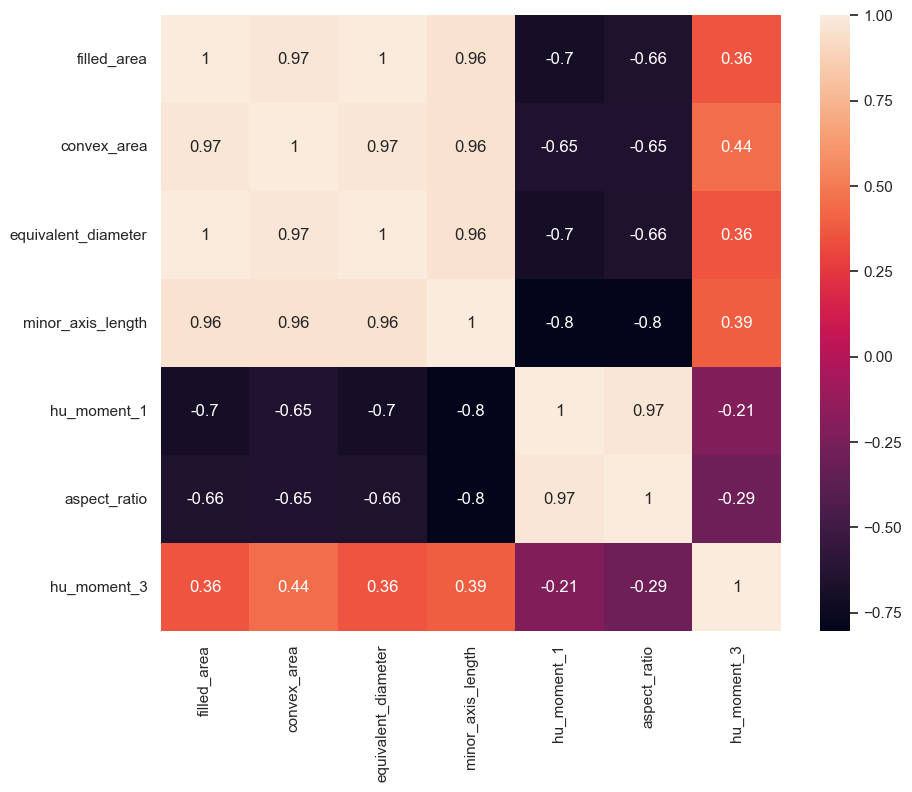

In [221]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X_train[['filled_area', "convex_area", 'equivalent_diameter', 'minor_axis_length', 'hu_moment_1', 'aspect_ratio', 'hu_moment_3']].corr(method='spearman')
sns.heatmap(corr, annot=True)
plt.show() 

array([[<Axes: xlabel='filled_area', ylabel='filled_area'>,
        <Axes: xlabel='convex_area', ylabel='filled_area'>,
        <Axes: xlabel='minor_axis_length', ylabel='filled_area'>,
        <Axes: xlabel='hu_moment_1', ylabel='filled_area'>,
        <Axes: xlabel='aspect_ratio', ylabel='filled_area'>,
        <Axes: xlabel='hu_moment_3', ylabel='filled_area'>],
       [<Axes: xlabel='filled_area', ylabel='convex_area'>,
        <Axes: xlabel='convex_area', ylabel='convex_area'>,
        <Axes: xlabel='minor_axis_length', ylabel='convex_area'>,
        <Axes: xlabel='hu_moment_1', ylabel='convex_area'>,
        <Axes: xlabel='aspect_ratio', ylabel='convex_area'>,
        <Axes: xlabel='hu_moment_3', ylabel='convex_area'>],
       [<Axes: xlabel='filled_area', ylabel='minor_axis_length'>,
        <Axes: xlabel='convex_area', ylabel='minor_axis_length'>,
        <Axes: xlabel='minor_axis_length', ylabel='minor_axis_length'>,
        <Axes: xlabel='hu_moment_1', ylabel='minor_axis_leng

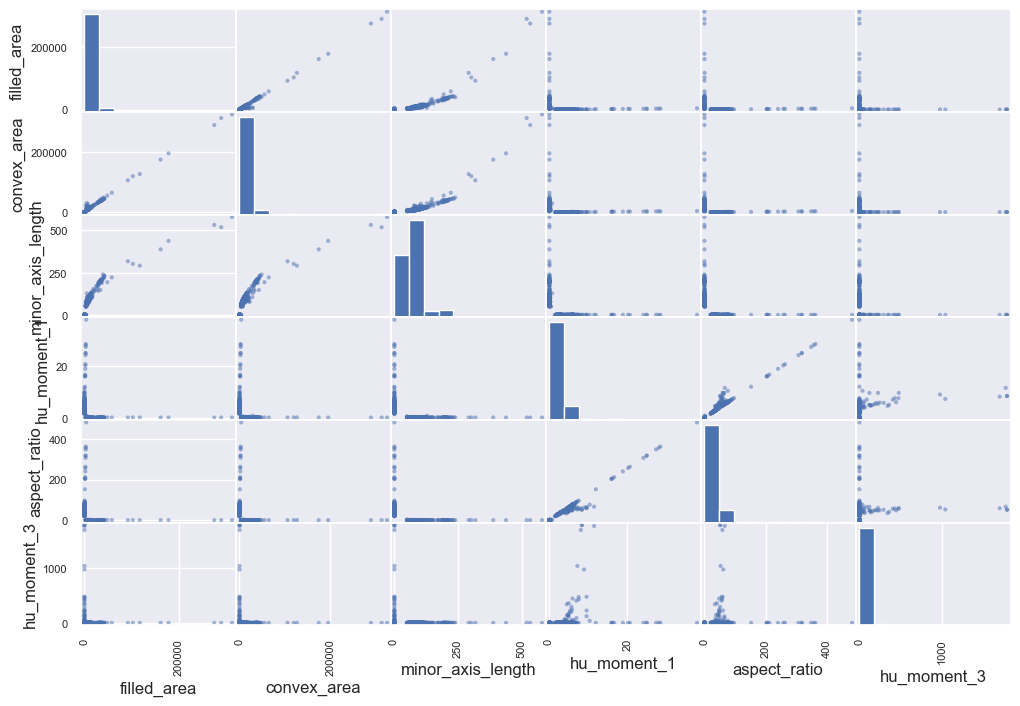

In [223]:
cols = ['filled_area', "convex_area", 'minor_axis_length', 'hu_moment_1', 'aspect_ratio', 'hu_moment_3']
scatter_matrix(X_train[cols], figsize=(12, 8))

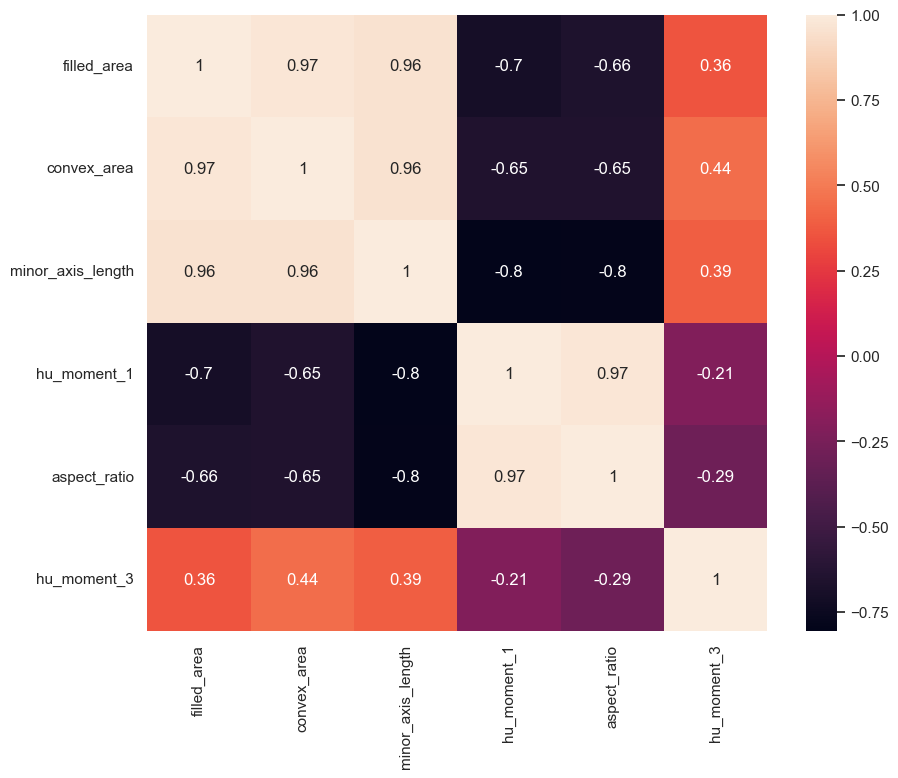

In [225]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X_train[cols].corr(method='spearman')
sns.heatmap(corr, annot=True)
plt.show() 

Se eliminan las variables: area, hu_moment_3 y equivalent_diameter que son las que se encuentran mayormente correlacionadas con las demás.

In [ ]:
X_train.drop(['area', 'hu_moment_3', 'equivalent_diameter'], axis=1, inplace = True) 
#Elimina las variables correlacionadas del estudio

# Selección de caracteristicas

## Correlación

In [ ]:
corr_matrix = df_properties.corr(method='spearman')
corr_matrix = corr_matrix.abs().unstack()
corr_matrix['label'].sort_values(ascending=False)  